# Training genre prediction models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Import local files

In [2]:
import sys
sys.path.append('../src/')
from training_keras import train_nn_fixed, grid_search_cv_nn
from preprocessing import preprocess_train, preprocess_test

## Preprocessing

Read & preprocess data

In [3]:
# Read data
df_train = pd.read_csv("../data/music_genre_train.csv")
#df_test = pd.read_csv("../data/music_genre_test.csv")

In [4]:
# Preprocess training data
res = preprocess_train(df_train)
df_train = res['dataframe']
utils_preprocessing = res['utils']

Split dataframe into X, y

In [5]:
X_train_val = df_train.drop('music_genre', axis=1)
y_train_val = df_train['music_genre']

## Training network with fixed architecture and hyperparameters using Keras

In [6]:
dict_nn = train_nn_fixed(X_train_val, y_train_val)

Epoch 1/50
938/938 [==============================] - 2s 1ms/step - loss: 1.7076 - accuracy: 0.5196 - val_loss: 1.4944 - val_accuracy: 0.5400
Epoch 2/50
938/938 [==============================] - 1s 1ms/step - loss: 1.4241 - accuracy: 0.5457 - val_loss: 1.3833 - val_accuracy: 0.5405
Epoch 3/50
938/938 [==============================] - 1s 1ms/step - loss: 1.3460 - accuracy: 0.5495 - val_loss: 1.3361 - val_accuracy: 0.5474
Epoch 4/50
938/938 [==============================] - 1s 1ms/step - loss: 1.3059 - accuracy: 0.5522 - val_loss: 1.3152 - val_accuracy: 0.5439
Epoch 5/50
938/938 [==============================] - 1s 1ms/step - loss: 1.2827 - accuracy: 0.5527 - val_loss: 1.2912 - val_accuracy: 0.5575
Epoch 6/50
938/938 [==============================] - 1s 1ms/step - loss: 1.2664 - accuracy: 0.5552 - val_loss: 1.2800 - val_accuracy: 0.5512
Epoch 7/50
938/938 [==============================] - 1s 1ms/step - loss: 1.2544 - accuracy: 0.5600 - val_loss: 1.2539 - val_accuracy: 0.5536
Epoch 

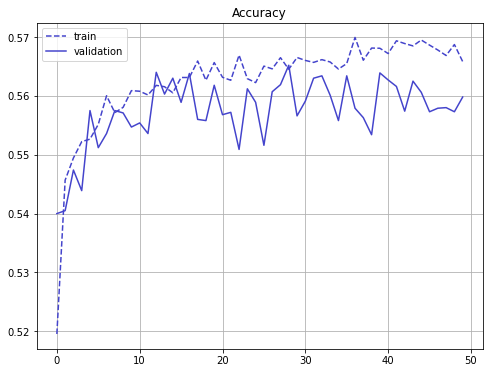

In [7]:
# Plot accuracy change over epochs
model_nn = dict_nn['model']
hist_nn = dict_nn['training_history']

plt.figure(figsize=(8, 6))
plt.plot(hist_nn.history['accuracy'], linestyle='--', color='#4444CC')
plt.plot(hist_nn.history['val_accuracy'], linestyle='-', color='#4444CC')
plt.legend(['train', 'validation'])
plt.grid()
plt.title("Accuracy")
plt.savefig('../images/nn_acc.jpg')
plt.show()

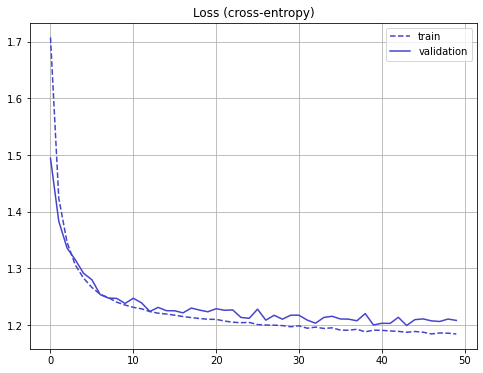

In [8]:
# Plot loss change over epochs
model_nn = dict_nn['model']
hist_nn = dict_nn['training_history']

plt.figure(figsize=(8, 6))
plt.plot(hist_nn.history['loss'], linestyle='--', color='#4444CC')
plt.plot(hist_nn.history['val_loss'], linestyle='-', color='#4444CC')
plt.legend(['train', 'validation'])
plt.grid()
plt.title("Loss (cross-entropy)")
plt.savefig('../images/nn_loss.jpg')
plt.show()

Prediction example

True label: Alternative
Predicted label: Electronic


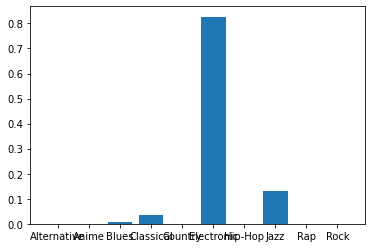

In [11]:
ind_sample = 1007

label_encoder = utils_preprocessing[0]
class_names = label_encoder.classes_

sample = X_train_val.iloc[ind_sample,:]
sample = np.array(sample)
sample = sample.reshape((1, -1))

sample_proba = model_nn.predict(sample)
sample_proba = sample_proba.flatten()

plt.bar(class_names, sample_proba)

sample_pred_label = np.argmax(sample_proba)
sample_pred_label = class_names[sample_pred_label]
sample_true_label = np.argmax(y_train_val.iloc[ind_sample])
sample_true_label = class_names[sample_true_label]

print("True label:", sample_true_label)
print("Predicted label:", sample_pred_label)

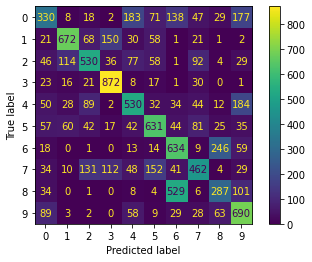

In [12]:
X_val = X_train_val.iloc[1000:11000]
y_val = y_train_val.iloc[1000:11000]
y_pred = model_nn.predict(X_val)
y_pred = [np.argmax(y_pred[i]) for i in range(len(y_pred))]

y_val = label_encoder.inverse_transform(y_val)
y_pred = label_encoder.inverse_transform(y_pred)

conf_matr = confusion_matrix(y_val, y_pred)
conf_matr_disp = ConfusionMatrixDisplay(conf_matr)
conf_matr_disp.plot()
plt.savefig('../images/nn_conf_matr.jpg')
plt.show()

## How much accuracy changes when we merge similar genres?

What happens if we merge rock wit alternative and hip-hop with rap?

In [13]:
y_val_alt = np.copy(y_val)
y_pred_alt = np.copy(y_pred)

In [14]:
for i in range(len(y_val_alt)):
    if y_val_alt[i] == 'Alternative' or y_val_alt[i] == 'Rock':
        y_val_alt[i] = 'Rock & Alternative'
    elif y_val_alt[i] == 'Rap' or y_val_alt[i] == 'Hip-Hop':
        y_val_alt[i] = 'Rap & Hip-Hop'

for i in range(len(y_pred_alt)):
    if y_pred_alt[i] == 'Alternative' or y_pred_alt[i] == 'Rock':
        y_pred_alt[i] = 'Rock & Alternative'
    elif y_pred_alt[i] == 'Rap' or y_pred_alt[i] == 'Hip-Hop':
        y_pred_alt[i] = 'Rap & Hip-Hop'

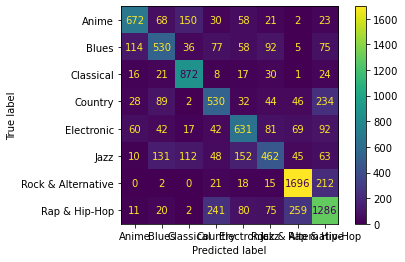

In [15]:
classes_merged = list(label_encoder.classes_)
classes_merged.remove('Alternative')
classes_merged.remove('Rock')
classes_merged.remove('Rap')
classes_merged.remove('Hip-Hop')
classes_merged.extend(['Rock & Alternative', 'Rap & Hip-Hop'])

conf_matr = confusion_matrix(y_val_alt, y_pred_alt)
conf_matr_disp = ConfusionMatrixDisplay(conf_matr, display_labels=classes_merged)
conf_matr_disp.plot()
plt.savefig('../images/nn_conf_matr_joined.jpg')
plt.show()

In [16]:
accuracy_score(y_pred_alt, y_val_alt)

0.6679

In [17]:
f1_score(y_pred_alt, y_val_alt, average='macro')

0.6460838772848216

## Hyperparameter tuning using Keras, grid search and CV

In [5]:
param_grid = {
    'optimizer' : ['adam'],
    'reg_rate_l2' : [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1],
    'activation' : ['relu'],
    'hidden_dim' : [100],
    'hidden_layers' : [4],
    'batch_size' : [32],
    'epochs' : [75]
}

In [6]:
res = grid_search_cv_nn(X_train_val, y_train_val, param_grid, verbose=True)

GRID SEARCH: 1 out of 7
FOLD: 1 / 4
Epoch 1/75
760/760 [==============================] - 2s 1ms/step - loss: 1.6835 - accuracy: 0.3987 - val_loss: 1.4715 - val_accuracy: 0.4839
Epoch 2/75
760/760 [==============================] - 1s 1ms/step - loss: 1.4153 - accuracy: 0.5017 - val_loss: 1.3796 - val_accuracy: 0.5267
Epoch 3/75
760/760 [==============================] - 1s 1ms/step - loss: 1.3470 - accuracy: 0.5243 - val_loss: 1.3335 - val_accuracy: 0.5330
Epoch 4/75
760/760 [==============================] - 1s 987us/step - loss: 1.3077 - accuracy: 0.5375 - val_loss: 1.3036 - val_accuracy: 0.5390
Epoch 5/75
760/760 [==============================] - 1s 995us/step - loss: 1.2807 - accuracy: 0.5437 - val_loss: 1.2810 - val_accuracy: 0.5461
Epoch 6/75
760/760 [==============================] - 1s 1ms/step - loss: 1.2633 - accuracy: 0.5462 - val_loss: 1.2696 - val_accuracy: 0.5490
Epoch 7/75
760/760 [==============================] - 1s 1ms/step - loss: 1.2496 - accuracy: 0.5528 - val_lo

Epoch 58/75
760/760 [==============================] - 1s 995us/step - loss: 1.1434 - accuracy: 0.5766 - val_loss: 1.1838 - val_accuracy: 0.5667
Epoch 59/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1406 - accuracy: 0.5769 - val_loss: 1.1777 - val_accuracy: 0.5744
Epoch 60/75
760/760 [==============================] - 1s 986us/step - loss: 1.1393 - accuracy: 0.5783 - val_loss: 1.1750 - val_accuracy: 0.5715
Epoch 61/75
760/760 [==============================] - 1s 995us/step - loss: 1.1407 - accuracy: 0.5780 - val_loss: 1.1715 - val_accuracy: 0.5744
Epoch 62/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1398 - accuracy: 0.5760 - val_loss: 1.1686 - val_accuracy: 0.5710
Epoch 63/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1378 - accuracy: 0.5783 - val_loss: 1.1737 - val_accuracy: 0.5678
Epoch 64/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1379 - accuracy: 0.5792 - val_loss: 1.1622 - val_accuracy: 

760/760 [==============================] - 1s 1ms/step - loss: 1.1936 - accuracy: 0.5655 - val_loss: 1.1975 - val_accuracy: 0.5559
Epoch 21/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1887 - accuracy: 0.5697 - val_loss: 1.2003 - val_accuracy: 0.5553
Epoch 22/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1891 - accuracy: 0.5655 - val_loss: 1.1914 - val_accuracy: 0.5569
Epoch 23/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1853 - accuracy: 0.5675 - val_loss: 1.1961 - val_accuracy: 0.5606
Epoch 24/75
760/760 [==============================] - 1s 986us/step - loss: 1.1851 - accuracy: 0.5694 - val_loss: 1.2017 - val_accuracy: 0.5524
Epoch 25/75
760/760 [==============================] - 1s 2ms/step - loss: 1.1834 - accuracy: 0.5665 - val_loss: 1.1889 - val_accuracy: 0.5574
Epoch 26/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1809 - accuracy: 0.5662 - val_loss: 1.1882 - val_accuracy: 0.5619
Epoch 27/

761/761 [==============================] - 1s 1ms/step - loss: 1.1453 - accuracy: 0.5755 - val_loss: 1.1717 - val_accuracy: 0.5661
Epoch 59/75
761/761 [==============================] - 1s 1ms/step - loss: 1.1436 - accuracy: 0.5747 - val_loss: 1.1777 - val_accuracy: 0.5600
Epoch 60/75
761/761 [==============================] - 1s 1ms/step - loss: 1.1436 - accuracy: 0.5771 - val_loss: 1.1721 - val_accuracy: 0.5654
Epoch 61/75
761/761 [==============================] - 1s 973us/step - loss: 1.1435 - accuracy: 0.5758 - val_loss: 1.1716 - val_accuracy: 0.5679
Epoch 62/75
761/761 [==============================] - 1s 969us/step - loss: 1.1423 - accuracy: 0.5757 - val_loss: 1.1668 - val_accuracy: 0.5671
Epoch 63/75
761/761 [==============================] - 1s 989us/step - loss: 1.1417 - accuracy: 0.5773 - val_loss: 1.1645 - val_accuracy: 0.5697
Epoch 64/75
761/761 [==============================] - 1s 965us/step - loss: 1.1414 - accuracy: 0.5745 - val_loss: 1.1676 - val_accuracy: 0.5670
Epo

760/760 [==============================] - 1s 1ms/step - loss: 1.1792 - accuracy: 0.5698 - val_loss: 1.2001 - val_accuracy: 0.5642
Epoch 21/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1773 - accuracy: 0.5735 - val_loss: 1.1936 - val_accuracy: 0.5648
Epoch 22/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1750 - accuracy: 0.5709 - val_loss: 1.1995 - val_accuracy: 0.5635
Epoch 23/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1742 - accuracy: 0.5718 - val_loss: 1.2009 - val_accuracy: 0.5604
Epoch 24/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1714 - accuracy: 0.5717 - val_loss: 1.1933 - val_accuracy: 0.5612
Epoch 25/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1709 - accuracy: 0.5721 - val_loss: 1.1941 - val_accuracy: 0.5625
Epoch 26/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1692 - accuracy: 0.5712 - val_loss: 1.1870 - val_accuracy: 0.5648
Epoch 27/75

Epoch 58/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1496 - accuracy: 0.5778 - val_loss: 1.1615 - val_accuracy: 0.5668
Epoch 59/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1490 - accuracy: 0.5758 - val_loss: 1.1737 - val_accuracy: 0.5604
Epoch 60/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1492 - accuracy: 0.5763 - val_loss: 1.1713 - val_accuracy: 0.5665
Epoch 61/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1489 - accuracy: 0.5756 - val_loss: 1.1565 - val_accuracy: 0.5737
Epoch 62/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1491 - accuracy: 0.5747 - val_loss: 1.1558 - val_accuracy: 0.5694
Epoch 63/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1461 - accuracy: 0.5743 - val_loss: 1.1701 - val_accuracy: 0.5661
Epoch 64/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1477 - accuracy: 0.5784 - val_loss: 1.1643 - val_accuracy: 0.5652

760/760 [==============================] - 1s 1ms/step - loss: 1.1927 - accuracy: 0.5689 - val_loss: 1.2169 - val_accuracy: 0.5619
Epoch 21/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1907 - accuracy: 0.5659 - val_loss: 1.2180 - val_accuracy: 0.5680
Epoch 22/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1866 - accuracy: 0.5682 - val_loss: 1.2122 - val_accuracy: 0.5667
Epoch 23/75
760/760 [==============================] - 1s 972us/step - loss: 1.1851 - accuracy: 0.5675 - val_loss: 1.2122 - val_accuracy: 0.5661
Epoch 24/75
760/760 [==============================] - 1s 987us/step - loss: 1.1833 - accuracy: 0.5678 - val_loss: 1.2087 - val_accuracy: 0.5647
Epoch 25/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1808 - accuracy: 0.5674 - val_loss: 1.2157 - val_accuracy: 0.5614
Epoch 26/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1787 - accuracy: 0.5684 - val_loss: 1.2067 - val_accuracy: 0.5641
Epoch 2

760/760 [==============================] - 1s 1ms/step - loss: 1.1408 - accuracy: 0.5769 - val_loss: 1.1614 - val_accuracy: 0.5730
Epoch 59/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1397 - accuracy: 0.5753 - val_loss: 1.1729 - val_accuracy: 0.5725
Epoch 60/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1384 - accuracy: 0.5763 - val_loss: 1.1680 - val_accuracy: 0.5747
Epoch 61/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1389 - accuracy: 0.5772 - val_loss: 1.1681 - val_accuracy: 0.5749
Epoch 62/75
760/760 [==============================] - 1s 986us/step - loss: 1.1380 - accuracy: 0.5790 - val_loss: 1.1637 - val_accuracy: 0.5728
Epoch 63/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1376 - accuracy: 0.5806 - val_loss: 1.1721 - val_accuracy: 0.5675
Epoch 64/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1362 - accuracy: 0.5780 - val_loss: 1.1728 - val_accuracy: 0.5668
Epoch 65/

Epoch 21/75
761/761 [==============================] - 1s 1ms/step - loss: 1.1830 - accuracy: 0.5666 - val_loss: 1.2053 - val_accuracy: 0.5575
Epoch 22/75
761/761 [==============================] - 1s 1ms/step - loss: 1.1804 - accuracy: 0.5679 - val_loss: 1.2085 - val_accuracy: 0.5591
Epoch 23/75
761/761 [==============================] - 1s 1ms/step - loss: 1.1807 - accuracy: 0.5690 - val_loss: 1.2017 - val_accuracy: 0.5585
Epoch 24/75
761/761 [==============================] - 1s 1ms/step - loss: 1.1786 - accuracy: 0.5716 - val_loss: 1.2010 - val_accuracy: 0.5601
Epoch 25/75
761/761 [==============================] - 1s 1ms/step - loss: 1.1754 - accuracy: 0.5711 - val_loss: 1.2103 - val_accuracy: 0.5597
Epoch 26/75
761/761 [==============================] - 1s 1ms/step - loss: 1.1732 - accuracy: 0.5723 - val_loss: 1.1988 - val_accuracy: 0.5577
Epoch 27/75
761/761 [==============================] - 1s 1ms/step - loss: 1.1719 - accuracy: 0.5701 - val_loss: 1.2020 - val_accuracy: 0.5574

760/760 [==============================] - 1s 1ms/step - loss: 1.1395 - accuracy: 0.5739 - val_loss: 1.1835 - val_accuracy: 0.5707
Epoch 60/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1400 - accuracy: 0.5765 - val_loss: 1.1794 - val_accuracy: 0.5695
Epoch 61/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1393 - accuracy: 0.5790 - val_loss: 1.1840 - val_accuracy: 0.5659
Epoch 62/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1385 - accuracy: 0.5762 - val_loss: 1.1737 - val_accuracy: 0.5748
Epoch 63/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1398 - accuracy: 0.5763 - val_loss: 1.1693 - val_accuracy: 0.5712
Epoch 64/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1371 - accuracy: 0.5760 - val_loss: 1.1754 - val_accuracy: 0.5747
Epoch 65/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1376 - accuracy: 0.5767 - val_loss: 1.1787 - val_accuracy: 0.5717
Epoch 66/75

Epoch 41/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1570 - accuracy: 0.5711 - val_loss: 1.1812 - val_accuracy: 0.5710
Epoch 42/75
760/760 [==============================] - 1s 2ms/step - loss: 1.1563 - accuracy: 0.5764 - val_loss: 1.1710 - val_accuracy: 0.5719
Epoch 43/75
760/760 [==============================] - 1s 2ms/step - loss: 1.1548 - accuracy: 0.5736 - val_loss: 1.1791 - val_accuracy: 0.5695
Epoch 44/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1554 - accuracy: 0.5745 - val_loss: 1.1711 - val_accuracy: 0.5751
Epoch 45/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1559 - accuracy: 0.5736 - val_loss: 1.1782 - val_accuracy: 0.5725
Epoch 46/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1528 - accuracy: 0.5756 - val_loss: 1.1784 - val_accuracy: 0.5716
Epoch 47/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1517 - accuracy: 0.5751 - val_loss: 1.1749 - val_accuracy: 0.5686

761/761 [==============================] - 1s 1ms/step - loss: 1.3295 - accuracy: 0.5286 - val_loss: 1.3315 - val_accuracy: 0.5164
Epoch 4/75
761/761 [==============================] - 1s 1ms/step - loss: 1.2948 - accuracy: 0.5383 - val_loss: 1.3049 - val_accuracy: 0.5252
Epoch 5/75
761/761 [==============================] - 1s 1ms/step - loss: 1.2724 - accuracy: 0.5464 - val_loss: 1.2881 - val_accuracy: 0.5339
Epoch 6/75
761/761 [==============================] - 1s 1ms/step - loss: 1.2542 - accuracy: 0.5488 - val_loss: 1.2716 - val_accuracy: 0.5370
Epoch 7/75
761/761 [==============================] - 1s 1ms/step - loss: 1.2428 - accuracy: 0.5530 - val_loss: 1.2632 - val_accuracy: 0.5432
Epoch 8/75
761/761 [==============================] - 1s 1ms/step - loss: 1.2356 - accuracy: 0.5537 - val_loss: 1.2555 - val_accuracy: 0.5438
Epoch 9/75
761/761 [==============================] - 1s 1ms/step - loss: 1.2254 - accuracy: 0.5587 - val_loss: 1.2447 - val_accuracy: 0.5498
Epoch 10/75
761/7

760/760 [==============================] - 1s 1ms/step - loss: 1.1582 - accuracy: 0.5709 - val_loss: 1.1930 - val_accuracy: 0.5680
Epoch 42/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1555 - accuracy: 0.5718 - val_loss: 1.1908 - val_accuracy: 0.5690
Epoch 43/75
760/760 [==============================] - 1s 2ms/step - loss: 1.1545 - accuracy: 0.5722 - val_loss: 1.1879 - val_accuracy: 0.5633
Epoch 44/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1542 - accuracy: 0.5740 - val_loss: 1.1923 - val_accuracy: 0.5693
Epoch 45/75
760/760 [==============================] - 1s 2ms/step - loss: 1.1546 - accuracy: 0.5746 - val_loss: 1.1841 - val_accuracy: 0.5731
Epoch 46/75
760/760 [==============================] - 2s 2ms/step - loss: 1.1538 - accuracy: 0.5739 - val_loss: 1.1909 - val_accuracy: 0.5684
Epoch 47/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1512 - accuracy: 0.5749 - val_loss: 1.1914 - val_accuracy: 0.5636
Epoch 48/75

760/760 [==============================] - 1s 1ms/step - loss: 1.3548 - accuracy: 0.5269 - val_loss: 1.3356 - val_accuracy: 0.5188
Epoch 4/75
760/760 [==============================] - 1s 1ms/step - loss: 1.3126 - accuracy: 0.5355 - val_loss: 1.3122 - val_accuracy: 0.5313
Epoch 5/75
760/760 [==============================] - 1s 1ms/step - loss: 1.2848 - accuracy: 0.5426 - val_loss: 1.2858 - val_accuracy: 0.5398
Epoch 6/75
760/760 [==============================] - 1s 1ms/step - loss: 1.2649 - accuracy: 0.5499 - val_loss: 1.2655 - val_accuracy: 0.5424
Epoch 7/75
760/760 [==============================] - 1s 1ms/step - loss: 1.2511 - accuracy: 0.5522 - val_loss: 1.2552 - val_accuracy: 0.5416
Epoch 8/75
760/760 [==============================] - 1s 1ms/step - loss: 1.2405 - accuracy: 0.5569 - val_loss: 1.2469 - val_accuracy: 0.5483
Epoch 9/75
760/760 [==============================] - 1s 1ms/step - loss: 1.2315 - accuracy: 0.5605 - val_loss: 1.2399 - val_accuracy: 0.5447
Epoch 10/75
760/7

761/761 [==============================] - 1s 1ms/step - loss: 1.1514 - accuracy: 0.5757 - val_loss: 1.1798 - val_accuracy: 0.5634
Epoch 42/75
761/761 [==============================] - 1s 1ms/step - loss: 1.1525 - accuracy: 0.5760 - val_loss: 1.1836 - val_accuracy: 0.5580
Epoch 43/75
761/761 [==============================] - 1s 1ms/step - loss: 1.1515 - accuracy: 0.5734 - val_loss: 1.1838 - val_accuracy: 0.5593
Epoch 44/75
761/761 [==============================] - 1s 1ms/step - loss: 1.1495 - accuracy: 0.5793 - val_loss: 1.1767 - val_accuracy: 0.5624
Epoch 45/75
761/761 [==============================] - 1s 1ms/step - loss: 1.1495 - accuracy: 0.5786 - val_loss: 1.1894 - val_accuracy: 0.5590
Epoch 46/75
761/761 [==============================] - 1s 1ms/step - loss: 1.1470 - accuracy: 0.5761 - val_loss: 1.1892 - val_accuracy: 0.5539
Epoch 47/75
761/761 [==============================] - 1s 1ms/step - loss: 1.1483 - accuracy: 0.5761 - val_loss: 1.1808 - val_accuracy: 0.5606
Epoch 48/75

760/760 [==============================] - 1s 1ms/step - loss: 1.3344 - accuracy: 0.5315 - val_loss: 1.3087 - val_accuracy: 0.5455
Epoch 4/75
760/760 [==============================] - 1s 1ms/step - loss: 1.3012 - accuracy: 0.5403 - val_loss: 1.2962 - val_accuracy: 0.5411
Epoch 5/75
760/760 [==============================] - 1s 1ms/step - loss: 1.2799 - accuracy: 0.5423 - val_loss: 1.2706 - val_accuracy: 0.5477
Epoch 6/75
760/760 [==============================] - 1s 1ms/step - loss: 1.2636 - accuracy: 0.5507 - val_loss: 1.2538 - val_accuracy: 0.5567
Epoch 7/75
760/760 [==============================] - 1s 1ms/step - loss: 1.2506 - accuracy: 0.5508 - val_loss: 1.2440 - val_accuracy: 0.5583
Epoch 8/75
760/760 [==============================] - 1s 1ms/step - loss: 1.2414 - accuracy: 0.5531 - val_loss: 1.2369 - val_accuracy: 0.5550
Epoch 9/75
760/760 [==============================] - 1s 1ms/step - loss: 1.2322 - accuracy: 0.5565 - val_loss: 1.2292 - val_accuracy: 0.5585
Epoch 10/75
760/7

760/760 [==============================] - 1s 987us/step - loss: 1.1544 - accuracy: 0.5793 - val_loss: 1.1813 - val_accuracy: 0.5589
Epoch 42/75
760/760 [==============================] - 1s 952us/step - loss: 1.1540 - accuracy: 0.5759 - val_loss: 1.1825 - val_accuracy: 0.5607
Epoch 43/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1539 - accuracy: 0.5769 - val_loss: 1.1737 - val_accuracy: 0.5653
Epoch 44/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1531 - accuracy: 0.5761 - val_loss: 1.1686 - val_accuracy: 0.5663
Epoch 45/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1526 - accuracy: 0.5772 - val_loss: 1.1743 - val_accuracy: 0.5630
Epoch 46/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1513 - accuracy: 0.5771 - val_loss: 1.1676 - val_accuracy: 0.5643
Epoch 47/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1526 - accuracy: 0.5775 - val_loss: 1.1807 - val_accuracy: 0.5604
Epoch 4

Epoch 23/75
761/761 [==============================] - 1s 1ms/step - loss: 1.1848 - accuracy: 0.5683 - val_loss: 1.2219 - val_accuracy: 0.5464
Epoch 24/75
761/761 [==============================] - 1s 1ms/step - loss: 1.1848 - accuracy: 0.5663 - val_loss: 1.2270 - val_accuracy: 0.5524
Epoch 25/75
761/761 [==============================] - 1s 1ms/step - loss: 1.1808 - accuracy: 0.5694 - val_loss: 1.2073 - val_accuracy: 0.5585
Epoch 26/75
761/761 [==============================] - 1s 1ms/step - loss: 1.1788 - accuracy: 0.5679 - val_loss: 1.2095 - val_accuracy: 0.5539
Epoch 27/75
761/761 [==============================] - 1s 1ms/step - loss: 1.1759 - accuracy: 0.5698 - val_loss: 1.2055 - val_accuracy: 0.5604
Epoch 28/75
761/761 [==============================] - 1s 1ms/step - loss: 1.1799 - accuracy: 0.5674 - val_loss: 1.2070 - val_accuracy: 0.5575
Epoch 29/75
761/761 [==============================] - 1s 1ms/step - loss: 1.1737 - accuracy: 0.5702 - val_loss: 1.2047 - val_accuracy: 0.5608

760/760 [==============================] - 1s 1ms/step - loss: 1.1393 - accuracy: 0.5746 - val_loss: 1.1671 - val_accuracy: 0.5704
Epoch 62/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1392 - accuracy: 0.5775 - val_loss: 1.1753 - val_accuracy: 0.5679
Epoch 63/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1372 - accuracy: 0.5764 - val_loss: 1.1758 - val_accuracy: 0.5727
Epoch 64/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1384 - accuracy: 0.5752 - val_loss: 1.1699 - val_accuracy: 0.5688
Epoch 65/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1365 - accuracy: 0.5777 - val_loss: 1.1783 - val_accuracy: 0.5640
Epoch 66/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1360 - accuracy: 0.5764 - val_loss: 1.1730 - val_accuracy: 0.5659
Epoch 67/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1361 - accuracy: 0.5770 - val_loss: 1.1721 - val_accuracy: 0.5726
Epoch 68/75

760/760 [==============================] - 1s 968us/step - loss: 1.1759 - accuracy: 0.5722 - val_loss: 1.1926 - val_accuracy: 0.5585
Epoch 24/75
760/760 [==============================] - 1s 971us/step - loss: 1.1741 - accuracy: 0.5710 - val_loss: 1.1960 - val_accuracy: 0.5609
Epoch 25/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1731 - accuracy: 0.5697 - val_loss: 1.1934 - val_accuracy: 0.5548
Epoch 26/75
760/760 [==============================] - 1s 985us/step - loss: 1.1716 - accuracy: 0.5718 - val_loss: 1.1935 - val_accuracy: 0.5584
Epoch 27/75
760/760 [==============================] - 1s 973us/step - loss: 1.1707 - accuracy: 0.5707 - val_loss: 1.1840 - val_accuracy: 0.5641
Epoch 28/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1684 - accuracy: 0.5755 - val_loss: 1.1921 - val_accuracy: 0.5603
Epoch 29/75
760/760 [==============================] - 1s 1ms/step - loss: 1.1661 - accuracy: 0.5724 - val_loss: 1.1828 - val_accuracy: 0.5625
Epo

761/761 [==============================] - 1s 1ms/step - loss: 1.1423 - accuracy: 0.5748 - val_loss: 1.1695 - val_accuracy: 0.5666
Epoch 62/75
761/761 [==============================] - 1s 1ms/step - loss: 1.1420 - accuracy: 0.5773 - val_loss: 1.1690 - val_accuracy: 0.5634
Epoch 63/75
761/761 [==============================] - 1s 1ms/step - loss: 1.1405 - accuracy: 0.5800 - val_loss: 1.1763 - val_accuracy: 0.5645
Epoch 64/75
761/761 [==============================] - 1s 1ms/step - loss: 1.1402 - accuracy: 0.5763 - val_loss: 1.1783 - val_accuracy: 0.5609
Epoch 65/75
761/761 [==============================] - 1s 1ms/step - loss: 1.1400 - accuracy: 0.5775 - val_loss: 1.1639 - val_accuracy: 0.5676
Epoch 66/75
761/761 [==============================] - 1s 1ms/step - loss: 1.1414 - accuracy: 0.5755 - val_loss: 1.1717 - val_accuracy: 0.5621
Epoch 67/75
761/761 [==============================] - 1s 1ms/step - loss: 1.1372 - accuracy: 0.5799 - val_loss: 1.1630 - val_accuracy: 0.5682
Epoch 68/75

In [7]:
res

[{'model': <keras.engine.sequential.Sequential at 0x18466a2f4f0>,
  'val_accuracy': 0.5757986903190613,
  'hist': <keras.callbacks.History at 0x18469a8bf10>,
  'params': 'opt:adam, L2:0.0001, act:relu, hid_dim:100, hid_n:4, batch_size:32, epochs:75'},
 {'model': <keras.engine.sequential.Sequential at 0x18466fc80d0>,
  'val_accuracy': 0.5734550356864929,
  'hist': <keras.callbacks.History at 0x1846a07ea00>,
  'params': 'opt:adam, L2:0.0003, act:relu, hid_dim:100, hid_n:4, batch_size:32, epochs:75'},
 {'model': <keras.engine.sequential.Sequential at 0x1846ca3d580>,
  'val_accuracy': 0.5717281103134155,
  'hist': <keras.callbacks.History at 0x184666debb0>,
  'params': 'opt:adam, L2:0.001, act:relu, hid_dim:100, hid_n:4, batch_size:32, epochs:75'},
 {'model': <keras.engine.sequential.Sequential at 0x1846c824f70>,
  'val_accuracy': 0.5720981955528259,
  'hist': <keras.callbacks.History at 0x18469e054f0>,
  'params': 'opt:adam, L2:0.003, act:relu, hid_dim:100, hid_n:4, batch_size:32, epochs:

In [8]:
# Get best model
ind_best = 0
acc_best = 0
for i in range(len(res)):
    val_acc_last = res[i]['hist'].history['val_accuracy'][-1]
    if val_acc_last > acc_best:
        ind_best = i
        acc_best = val_acc_last
res_best = res[i]
res_best

{'model': <keras.engine.sequential.Sequential at 0x18469ee9550>,
 'val_accuracy': 0.5670408010482788,
 'hist': <keras.callbacks.History at 0x1840036bd90>,
 'params': 'opt:adam, L2:0.1, act:relu, hid_dim:100, hid_n:4, batch_size:32, epochs:75'}

In [9]:
print("Best model validation accuracy:", acc_best)

Best model validation accuracy: 0.5667406916618347


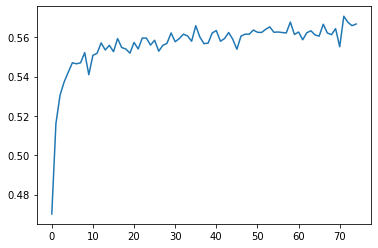

In [10]:
# Plot accuracy over epochs for best model
plt.plot(res[ind_best]['hist'].history['val_accuracy'])

In [11]:
model_best = res_best['model']
#model_best.save('../models/keras_0_572')

end